# Quantum Computer lab 2

These lab exercises are **NOT** part of the assesment of the module, but they should be useful training for the coursework.

* This notebook introduces some of the basic quantum circuit functionality in the pennylane module
* Please run the code to make sure it works, then try the questions.



##  Goals of the lab

* Investigate quantum phase estimation using a quantulm computer simulator
* Investigate the Quantum Fourier Transform

In later labs we will investigate introducing additional errors.

Computing eigenvalues of Hamiltonians is a key ingredient to Quantum Chemistry


## Installing pennylane




##  Installing pennylane on the University machines and your laptop

There are instructions on how to install pennylane on your computer at: https://pennylane.ai/install/

In the annaconda prompt or terminal on a Mac type 

pip install pennylane --upgrade

If you have spyder running you may need to restart spyder to access the library.

You will have to run this command everytime you work on a new PC in the lab.

There may be  additional complications with the University PCs,because of administrative rights. 




##  Question Quantum Phase Estimation

The aim of this section is to numerically investigate the quantum phase estimation algorithm. This is an algorithm to estimate the eigenvalue of a unitary matrix. We will first use a simple matrix with known eigenvalues.

* Background to Quantum Phase Estimation https://en.wikipedia.org/wiki/Quantum_phase_estimation_algorithm

* See the Pennylane tutorial https://pennylane.ai/qml/demos/tutorial_qpe/

We want to estimate the phase $\phi$

$$
U \mid \psi \rangle = e^{2 i \pi \phi } \mid \psi \rangle
$$




## First look at applying a single phase

In this example, we apply a 1 by 1 complex phase  $ e^{2 i \pi / 5 }$ so $\phi = 0.2$

To test the quantum phase estimation we input a known phase $\phi$
We can then check that the Quantum Phase Estimation can reproduce the known $\phi$


In [1]:
import pennylane as qml
import numpy as np

## This function applies the phase phi
def U(wires,phi):
    return qml.PhaseShift(2 * np.pi * phi, wires=wires)

In [2]:
dev = qml.device("default.qubit" )


## Below is a code to compute the phase using quantum phase estimation
@qml.qnode(dev)
def circuit_qpe(estimation_wires,phi):
    # initialize to state |1>
    qml.PauliX(wires=0)

    for wire in estimation_wires:
        qml.Hadamard(wires=wire)

    qml.ControlledSequence(U(wires=0,phi=phi), control=estimation_wires)

    qml.adjoint(qml.QFT)(wires=estimation_wires)

    return qml.probs(wires=estimation_wires)

## input parameters
The input phase $\phi$

The number of qubits to estimate the phase


In [3]:
phi_input = 0.2
measure_qubit = 5 

In [4]:
estimation_wires = range(1, measure_qubit)

## Plot the circuit

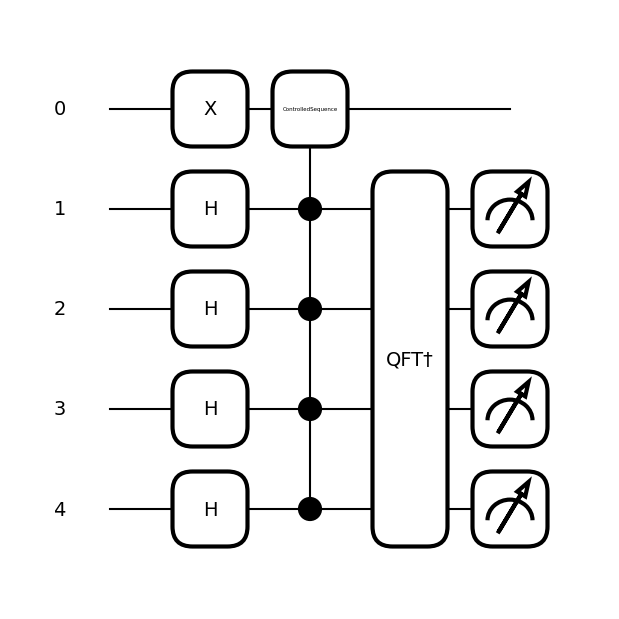

In [5]:
#  https://docs.pennylane.ai/en/stable/introduction/circuits.html

import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl( circuit_qpe)(estimation_wires,0.2)
    
plt.show()

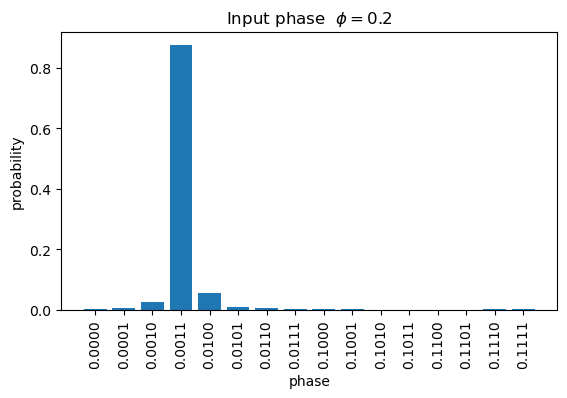

In [6]:
import matplotlib.pyplot as plt

estimation_wires = range(1, 5)

results = circuit_qpe(estimation_wires,phi_input)

bit_strings = [f"0.{x:0{len(estimation_wires)}b}" for x in range(len(results))]

plt.bar(bit_strings, results)
plt.xlabel("phase")
plt.ylabel("probability")
plt.xticks(rotation="vertical")
plt.subplots_adjust(bottom=0.3)
plt.title(r"Input phase  $\phi= $" + str(phi_input) )

plt.show()

The result for the phase is in the form of binary decimal notation  
$ x = 0. \phi_1 \phi_2 \phi_3 $   

where $\phi_j$ is 1 or  0

$x = \phi_1 / 2 + \phi_2 / 4 + \phi_3 / 8 $ 


##  Questions

*  For the input $\phi$ = 0.2 find the value of the phase estimated using 5 measuring qubits. You need to convert from binary in the histogram to a decimal fraction
*   For the input $\phi$ = 0.2 find the value of the phase estimated using 8 measuring qubits.
*  For the input $\phi$ = 0.125 find the value of the phase estimated using 5 measuring qubits.
*  For the input $\phi$ = 0.125 find the value of the phase estimated using 8 measuring qubits.
* comment on the above results


## Question 2

In this question, we will use the Quantum Phase estimation routine in PennyLane

https://docs.pennylane.ai/en/stable/code/api/pennylane.QuantumPhaseEstimation.html

It uses a two by two unitary matrix as input. It uses the $R_x$ gate https://docs.pennylane.ai/en/stable/code/api/pennylane.RX.html

The code now computes the phase of the $R_x$ unitary matrix.


In [7]:
import pennylane as qml
from pennylane.templates import QuantumPhaseEstimation
from pennylane import numpy as np

target_wires = [0]
# this phase is a parameter in the parameterized RX gate so it is not the same as the phase from the eigenvalue
phase = 5

qml.PauliX(wires=0)
unitary = qml.RX(phase, wires=0).matrix()

In [8]:
n_estimation_wires = 10
estimation_wires = range(1, n_estimation_wires + 1)

dev = qml.device("default.qubit", wires=n_estimation_wires + 1)

@qml.qnode(dev)
def circuit_unitary():
    # Start in the |+> eigenstate of the unitary
    qml.Hadamard(wires=target_wires)

    QuantumPhaseEstimation(
        unitary,
        target_wires=target_wires,
        estimation_wires=estimation_wires,
    )

    return qml.probs(estimation_wires)



Plot the cicuit

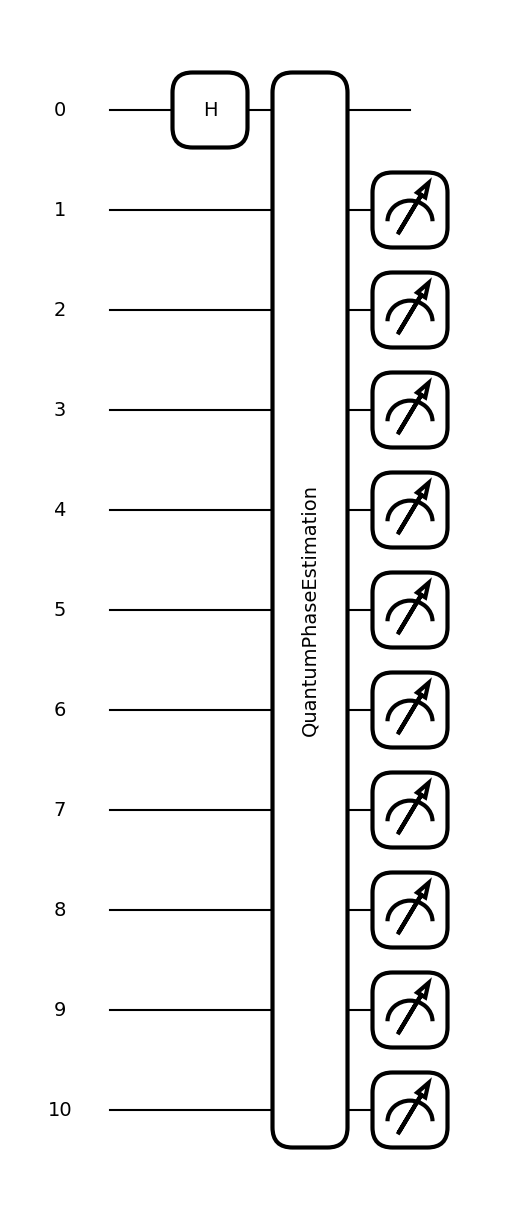

In [9]:
#  https://docs.pennylane.ai/en/stable/introduction/circuits.html

import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl( circuit_unitary)()
    
plt.show()

## Run the circuit 

In [10]:
phase_estimated = np.argmax(circuit_unitary()) / 2 ** n_estimation_wires

# Need to rescale phase due to convention of RX gate
#phase_estimated = 4 * np.pi * (1 - phase_estimated)

print(phase_estimated )

0.6025390625


## analyze the matrix

We can extract the matrix from the operator and use the standard eigenvalue tools of python to estimate the eigenvalues.
This will allow us to compute the phase and compare it to the 


In [11]:
print(unitary)

[[-0.80114362+0.j          0.        -0.59847214j]
 [ 0.        -0.59847214j -0.80114362+0.j        ]]


In [12]:
import numpy as np
from numpy import linalg as LA
import cmath
import math

eigenvalues, eigenvectors = LA.eig(unitary)

for e_ in eigenvalues :
#    p = (cmath.phase(e_)  + math.pi ) / (2.0 * math.pi )
    p =  cmath.phase(e_)
    if p <  0:
        p += 2*math.pi
    p = p / (2.0 * math.pi )
    print("Eigenvalue = " , e_, ",phase = ", p )

print("  ")
print("Eigenvectors = ")
print(eigenvectors)
print(" ")

#print( qml.RX(phase, wires=0).eigvals() )

Eigenvalue =  (-0.8011436155469338+0.5984721441039565j) ,phase =  0.3978873577297384
Eigenvalue =  (-0.8011436155469336-0.5984721441039565j) ,phase =  0.6021126422702616
  
Eigenvectors = 
[[ 0.70710678+0.00000000e+00j  0.70710678+0.00000000e+00j]
 [-0.70710678+0.00000000e+00j  0.70710678-2.15876699e-17j]]
 


### Questions

* What is the matrix used as input to the Quantum Phase Estimate?
* What is the estimate of $\phi$ for estimation_wires 5, 8, 10 ?
* There are two eigenvalues for $R_x$. Can you modify the circuit to estimate the second phase?


## Question 3 Quantum Fourier Transform

Based on the material from  https://pennylane.ai/qml/demos/tutorial_qft/


In [14]:
from scipy.linalg import dft
import pennylane as qml
import numpy as np

n = 2

print("DFT matrix for n = 2:\n")
print(np.round(1 / np.sqrt(2 ** n) * dft(2 ** n), 2))

qft_inverse = qml.adjoint(qml.QFT([0,1]))

print("\n inverse QFT matrix for n = 2:\n")
print(np.round(qft_inverse.matrix(), 2))

DFT matrix for n = 2:

[[ 0.5+0.j   0.5+0.j   0.5+0.j   0.5+0.j ]
 [ 0.5+0.j   0. -0.5j -0.5-0.j  -0. +0.5j]
 [ 0.5+0.j  -0.5-0.j   0.5+0.j  -0.5-0.j ]
 [ 0.5+0.j  -0. +0.5j -0.5-0.j   0. -0.5j]]

 inverse QFT matrix for n = 2:

[[ 0.5-0.j   0.5-0.j   0.5-0.j   0.5-0.j ]
 [ 0.5-0.j   0. -0.5j -0.5-0.j   0. +0.5j]
 [ 0.5-0.j  -0.5-0.j   0.5-0.j  -0.5-0.j ]
 [ 0.5-0.j   0. +0.5j -0.5-0.j   0. -0.5j]]


###  Question

* Try to write a Fourier Transform using the definitions on  https://pennylane.ai/qml/demos/tutorial_qft/